# Import

In [37]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.utils import plot_model
from PIL import Image

#Effcient net
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

Found 7395 files belonging to 7 classes.
Using 5916 files for training.
Found 7395 files belonging to 7 classes.
Using 1479 files for validation.
Class names: ['banana_overripe', 'banana_ripe', 'banana_rotten', 'banana_unripe', 'tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']

Class weights: {0: 0.6628571428571428, 1: 0.6702163815565877, 2: 0.4829387755102041, 3: 0.696163803247823, 4: 20.613240418118465, 5: 2.761904761904762, 6: 12.248447204968944}

=== CLASS VERIFICATION ===


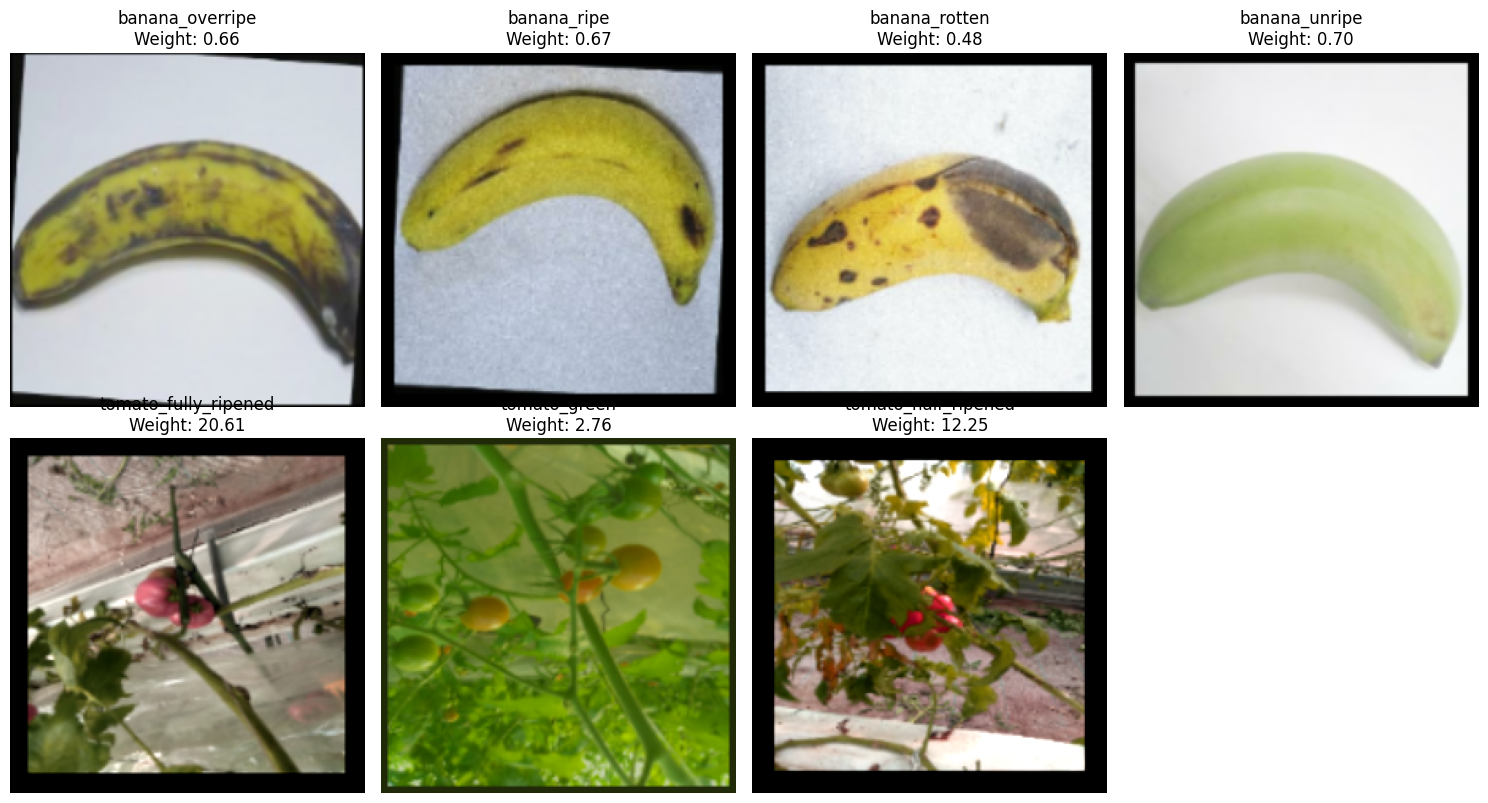

In [26]:
tf.random.set_seed(42)
np.random.seed(42)
img_size = 224
batch_size = 32
dataset_path = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Class names:", class_names)

# classes weights
labels = np.concatenate([y.numpy().argmax(1) for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', 
                                               classes=np.unique(labels), 
                                               y=labels)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)

# Augmentation
def general_augmentations(image):
    image = tf.image.resize(image, (160, 160))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    crop_size = tf.random.uniform([], minval=140, maxval=160, dtype=tf.int32)
    image = tf.image.resize(image, [crop_size, crop_size])
    image = tf.image.resize_with_crop_or_pad(image, 160, 160)
    return image

def tomato_extra_augmentations(image):
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.08)
    return image

# Indexes of tomato classes 
tomato_keywords = ['tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']
tomato_indices = [i for i, name in enumerate(class_names) if any(kw in name.lower() for kw in tomato_keywords)]
tomato_tensor = tf.constant(tomato_indices, dtype=tf.int64)

# process the imgs
def process_train(image, label):
    class_idx = tf.argmax(label)
    image = general_augmentations(image)
    is_tomato = tf.reduce_any(tf.equal(class_idx, tomato_tensor))
    image = tf.cond(
        is_tomato,
        lambda: tomato_extra_augmentations(image),
        lambda: image
    )
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def process_val(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Dataset pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds.unbatch()
           .map(process_train, num_parallel_calls=AUTOTUNE)
           .batch(batch_size))
val_ds = (val_ds.unbatch()
         .map(process_val, num_parallel_calls=AUTOTUNE)
         .batch(batch_size))
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Verification
print("\n=== CLASS VERIFICATION ===")

class_examples = {class_name: {'image': None, 'weight': None} for class_name in class_names}

for images, labels in train_ds:
    class_indices = tf.argmax(labels, axis=1).numpy()
    for i in range(len(class_indices)):
        class_name = class_names[class_indices[i]]
        if class_examples[class_name]['image'] is None:
            class_examples[class_name]['image'] = images[i]
            class_examples[class_name]['weight'] = class_weights[class_indices[i]]
    
    if all(v['image'] is not None for v in class_examples.values()):
        break

plt.figure(figsize=(15, 8))
for idx, (class_name, example) in enumerate(class_examples.items()):
    plt.subplot(2, 4, idx+1)  # Adjust grid based on number of classes
    plt.imshow(example['image'])
    plt.title(f"{class_name}\nWeight: {example['weight']:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,   # Split training set into train/val
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5917 images belonging to 7 classes.
Found 1478 images belonging to 7 classes.


In [28]:
input_shape = (224, 224, 3)
num_classes = 7
dropout_rate = 0.3
learning_rate = 1e-4
# ----------------------------------

# Load base EfficientNetV2B0 without the top
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Combine into model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile model with chosen learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 224, 224, 3)    │              0 │ rescaling_3[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 56, 56, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 56, 56, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 56, 56, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 56, 56, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 56, 56, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization) 

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.360386 to fit



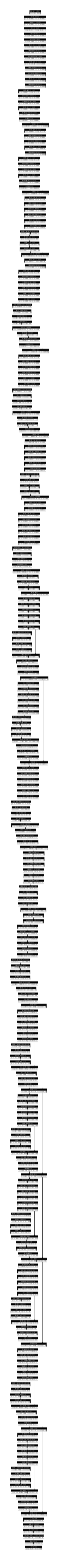

In [29]:
plot_model(model, to_file="efficientnetv2_architecture.png", show_shapes=True, show_layer_names=True)

# Open and scale the image (2x larger)
img = Image.open("efficientnetv2_architecture.png")
scaled_img = img.resize((img.width * 2, img.height * 2))
scaled_img.save("efficientnetv2_architecture_scaled.png")

# Display the scaled image
plt.figure(figsize=(20, 20))  # You can adjust this for better fit
plt.imshow(scaled_img)
plt.axis('off')
plt.show()

In [30]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 163s 719ms/step - accuracy: 0.3030 - loss: 1.7281 - val_accuracy: 0.7497 - val_loss: 1.0154
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 114s 597ms/step - accuracy: 0.7138 - loss: 0.9515 - val_accuracy: 0.8417 - val_loss: 0.7074
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 118s 615ms/step - accuracy: 0.8271 - loss: 0.6762 - val_accuracy: 0.8843 - val_loss: 0.5593
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 118s 616ms/step - accuracy: 0.8569 - loss: 0.5559 - val_accuracy: 0.8911 - val_loss: 0.4701
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 115s 606ms/step - accuracy: 0.8686 - loss: 0.4804 - val_accuracy: 0.9053 - val_loss: 0.4128
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 116s 606ms/step - accuracy: 0.8894 - loss: 0.4199 - val_accuracy: 0.9060 - val_loss: 0.3728
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 116s 609ms/step - accuracy: 0.8987 - loss: 0.3856 - val_accuracy: 0.9093 - val_loss: 0.3392
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 120s 628ms/step - accuracy: 0.9039 - loss: 0.35

In [40]:
test_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/test/testNew' 
filenames = [f for f in os.listdir(test_dir) if f.lower().endswith('.jpg')]
filepaths = [os.path.join(test_dir, fname) for fname in filenames]
df = pd.DataFrame({'filename': filepaths})

# Create ImageDataGenerator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create test generator using flow_from_dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filename',
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # no labels
    shuffle=False
)

Found 2484 validated image filenames.


In [41]:
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 704ms/step


In [43]:
filenames = test_generator.filenames  
image_ids = [fname.split('/')[-1] for fname in filenames]
class_labels = list(train_generator.class_indices.keys())
pred_class_labels = [class_labels[i] for i in pred_classes]
df = pd.DataFrame({
    'ImageID': image_ids,
    'Class': pred_classes
})

df.to_csv('/kaggle/working/effcientnet_predictions.csv', index=False)
print('saved successfully')

saved successfully
